# 01 - Simple features, class imbalance, no outlier treatment

In this notebook I "get something working" ... that is, I load the data, filter timeframes, create simple features, train models with default parameters.

My intent is to get working code in place for deeper analysis in subsequent notebooks.   As I develop re-usable pieces that do not have much likelihood to changing in subsequent notebooks, I'll refactor those and tuck them away.


In [32]:
import duckdb
import polars as pl
import pyarrow


In [33]:
# There are other ways to download the files.
# For this project I do not use the images (which take a long time)
# Get a cup of coffee or change to one file at a time
# Better than kaggle docs: https://stackoverflow.com/questions/55934733/documentation-for-kaggle-api-within-python

import os
from kaggle.api.kaggle_api_extended import KaggleApi

# not positive this is needed ...
# os.environ['KAGGLE_CONFIG_DIR'] = '/Users/rogerteffen/.kaggle/'
# print(os.environ['KAGGLE_CONFIG_DIR'])

api = KaggleApi()
api.authenticate()

data_set = 'h-and-m-personalized-fashion-recommendations'

# Download all files for a competition
# Signature: competition_download_files(competition, path=None, force=False, quiet=True)
# api.competition_download_files('h-and-m-personalized-fashion-recommendations',
#                                path='../data')


api.competition_download_file('h-and-m-personalized-fashion-recommendations',
                              'articles.csv',path='../data')
api.competition_download_file('h-and-m-personalized-fashion-recommendations',
                              'customers.csv',path='../data')
api.competition_download_file('h-and-m-personalized-fashion-recommendations',
                              'transactions_train.csv',path='../data')


articles.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
customers.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
transactions_train.csv.zip: Skipping, found more recently modified local copy (use --force to force download)


In [34]:
# Define the directory containing the .zip files
zip_dir = '../data'
destination_dir = '../data'

# Create the destination directory if it doesn't exist
os.makedirs(destination_dir, exist_ok=True)

# Iterate through all files in the directory
for file in os.listdir(zip_dir):
    if file.endswith('.zip'):
        # Construct full path to the zip file
        zip_path = os.path.join(zip_dir, file)

        # Unzip the file
        os.system(f"unzip -o {zip_path} -d {destination_dir}")
        print(f"Unzipped: {file}")


Archive:  ../data/customers.csv.zip
  inflating: ../data/customers.csv   
Unzipped: customers.csv.zip
Archive:  ../data/articles.csv.zip
  inflating: ../data/articles.csv    
Unzipped: articles.csv.zip
Archive:  ../data/transactions_train.csv.zip
  inflating: ../data/transactions_train.csv  
Unzipped: transactions_train.csv.zip


In [35]:
def load_file_into_view(filename: str, viewname: str, duckdb_conn):
    # Load a CSV into a Polars DataFrame
    file_path = filename
    polars_df = pl.read_csv(file_path, schema_overrides={"t_dat": pl.Date, "article_id": pl.Utf8})

    # Register the Polars DataFrame as a DuckDB table
    # DuckDB can directly use Polars objects without conversion

    duckdb_conn.register(viewname, polars_df)

def load_data_into_duck():
    files = ["articles.csv","transactions_train.csv","customers.csv"]
    path = "../data/"
    duckdb_conn = duckdb.connect()
    for file in files:
        print(f"Loading {path+file}")
        table = file.replace(".csv","")
        table = table.replace("_train","")
        load_file_into_view(path+file,table,duckdb_conn)
    return duckdb_conn

duckdb_conn = load_data_into_duck()


Loading ../data/articles.csv
Loading ../data/transactions_train.csv
Loading ../data/customers.csv


In [36]:
from IPython.display import display, HTML
from itables import init_notebook_mode

# consider sub-classing duckdb_conn with this function?
# I needed to turn off interactivity for results to show in github
def run_query_display_results(duckdb_conn: duckdb.duckdb.DuckDBPyConnection, query: str):

    init_notebook_mode(all_interactive=False)

    # Execute the query and fetch results as an Arrow Table
    arrow_table = duckdb_conn.execute(query).fetch_arrow_table()

    # Convert the Arrow Table to a Polars DataFrame
    polars_df = pl.from_arrow(arrow_table)

    display(polars_df)

    return polars_df


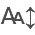

shape: (100, 5)
┌────────────┬─────────────────────────────────┬────────────┬──────────┬──────────────────┐
│ t_dat      ┆ customer_id                     ┆ article_id ┆ price    ┆ sales_channel_id │
│ ---        ┆ ---                             ┆ ---        ┆ ---      ┆ ---              │
│ date       ┆ str                             ┆ str        ┆ f64      ┆ i64              │
╞════════════╪═════════════════════════════════╪════════════╪══════════╪══════════════════╡
│ 2018-09-20 ┆ 000058a12d5b43e67d225668fa1f8d… ┆ 0663713001 ┆ 0.050831 ┆ 2                │
│ 2018-09-20 ┆ 000058a12d5b43e67d225668fa1f8d… ┆ 0541518023 ┆ 0.030492 ┆ 2                │
│ 2018-09-20 ┆ 00007d2de826758b65a93dd24ce629… ┆ 0505221004 ┆ 0.015237 ┆ 2                │
│ 2018-09-20 ┆ 00007d2de826758b65a93dd24ce629… ┆ 0685687003 ┆ 0.016932 ┆ 2                │
│ 2018-09-20 ┆ 00007d2de826758b65a93dd24ce629… ┆ 0685687004 ┆ 0.016932 ┆ 2                │
│ …          ┆ …                               ┆ …          ┆ …        ┆ …                │
│ 2018-09-20 ┆ 00761aefe07a2dd6ca110c99f3856e… ┆ 0633781016 ┆ 0.015237 ┆ 1                │
│ 2018-09-20 ┆ 0077ba345ef6aa8781802107df25bb… ┆ 0534795002 ┆ 0.011864 ┆ 1                │
│ 2018-09-20 ┆ 00796ce0bc561897e7047a7b059867… ┆ 0659550001 ┆ 0.059305 ┆ 2                │
│ 2018-09-20 ┆ 007e4c2e0994b4aac97c2713d5dc0b… ┆ 0547752003 ┆ 0.040661 ┆ 2                │
│ 2018-09-20 ┆ 007ea762fbbebfad288a49f1d8f7c2… ┆ 0610671001 ┆ 0.013542 ┆ 1                │
└────────────┴─────────────────────────────────┴────────────┴──────────┴──────────────────┘


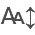

shape: (100, 2)
┌─────────────────────────────────┬────────────────────────┐
│ customer_id                     ┆ transaction_item_count │
│ ---                             ┆ ---                    │
│ str                             ┆ i64                    │
╞═════════════════════════════════╪════════════════════════╡
│ be1981ab818cf4ef6765b2ecaea7a2… ┆ 1895                   │
│ b4db5e5259234574edfff958e170fe… ┆ 1441                   │
│ 49beaacac0c7801c2ce2d189efe525… ┆ 1364                   │
│ a65f77281a528bf5c1e9f270141d60… ┆ 1361                   │
│ cd04ec2726dd58a8c753e0d6423e57… ┆ 1237                   │
│ …                               ┆ …                      │
│ a3a49e164a72731d400297d5d182ef… ┆ 724                    │
│ d3cc9c591adf39a42fe82fe6a16acb… ┆ 722                    │
│ 9dbc055471e6893cb38124538ae0b6… ┆ 715                    │
│ 58388c01c7fded48c321e36282daf9… ┆ 715                    │
│ d9d809b2a22dfe4afcbe5351c5c3ca… ┆ 715                    │
└─────────────────────────────────┴────────────────────────┘

shape: (100, 2)
┌─────────────────────────────────┬────────────────────────┐
│ customer_id                     ┆ transaction_item_count │
│ ---                             ┆ ---                    │
│ str                             ┆ i64                    │
╞═════════════════════════════════╪════════════════════════╡
│ be1981ab818cf4ef6765b2ecaea7a2… ┆ 1895                   │
│ b4db5e5259234574edfff958e170fe… ┆ 1441                   │
│ 49beaacac0c7801c2ce2d189efe525… ┆ 1364                   │
│ a65f77281a528bf5c1e9f270141d60… ┆ 1361                   │
│ cd04ec2726dd58a8c753e0d6423e57… ┆ 1237                   │
│ …                               ┆ …                      │
│ a3a49e164a72731d400297d5d182ef… ┆ 724                    │
│ d3cc9c591adf39a42fe82fe6a16acb… ┆ 722                    │
│ 9dbc055471e6893cb38124538ae0b6… ┆ 715                    │
│ 58388c01c7fded48c321e36282daf9… ┆ 715                    │
│ d9d809b2a22dfe4afcbe5351c5c3ca… ┆ 715                    │
└─────────────────────────────────┴────────────────────────┘

In [37]:
query = '''
    SELECT
        *
    FROM transactions
    LIMIT 100
'''


run_query_display_results(duckdb_conn, query)

query = '''
    SELECT
        customer_id, count(1) as transaction_item_count
    FROM transactions
    GROUP BY customer_id
    ORDER BY 2 desc
    LIMIT 100
'''

run_query_display_results(duckdb_conn, query)

From here we will assume a connection to a database: duckdb_conn
Via this connection I will run queries to pull transaction & customer data to build a model to predict who will make a purchase in the next 30 days.

I will maintain the columns from the original data source to make it easier to recreate this all within Kaggle.







feature_start:  2019-07-25
feature_end:  2020-07-24
label_end:  2020-08-23



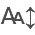

shape: (2, 2)
┌───────┬─────────┐
│ label ┆ cnt     │
│ ---   ┆ ---     │
│ i32   ┆ i64     │
╞═══════╪═════════╡
│ 1     ┆ 246426  │
│ 0     ┆ 1115855 │
└───────┴─────────┘


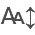

shape: (50, 5)
┌─────────────────────┬─────────────────────┬─────────────────┬───────────────┬────────────────────┐
│ customer_id         ┆ total_transaction_i ┆ days_since_last ┆ total_revenue ┆ total_transactions │
│ ---                 ┆ tems                ┆ ---             ┆ ---           ┆ ---                │
│ str                 ┆ ---                 ┆ i64             ┆ f64           ┆ i64                │
│                     ┆ i64                 ┆                 ┆               ┆                    │
╞═════════════════════╪═════════════════════╪═════════════════╪═══════════════╪════════════════════╡
│ a65f77281a528bf5c1e ┆ 692                 ┆ 0               ┆ 15941.0       ┆ 208                │
│ 9f270141d60…        ┆                     ┆                 ┆               ┆                    │
│ 8df45859ccd71ef1e48 ┆ 609                 ┆ 1               ┆ 12100.0       ┆ 200                │
│ e2ee9d1c65d…        ┆                     ┆                 ┆               ┆                    │
│ f137c16fd175271922d ┆ 464                 ┆ 0               ┆ 10672.0       ┆ 190                │
│ ad400656550…        ┆                     ┆                 ┆               ┆                    │
│ e34f8aa5e7c8c258523 ┆ 694                 ┆ 0               ┆ 8296.0        ┆ 184                │
│ ea3e5f5f131…        ┆                     ┆                 ┆               ┆                    │
│ 6e378d7d9f037a2dc5f ┆ 629                 ┆ 4               ┆ 6753.0        ┆ 163                │
│ 2792656934c…        ┆                     ┆                 ┆               ┆                    │
│ …                   ┆ …                   ┆ …               ┆ …             ┆ …                  │
│ 4fd20fa4ccc486b89c4 ┆ 395                 ┆ 0               ┆ 9573.0        ┆ 105                │
│ 325446c5b9d…        ┆                     ┆                 ┆               ┆                    │
│ 33a6a3b2f8453191457 ┆ 389                 ┆ 5               ┆ 8013.0        ┆ 103                │
│ 1bf4f7ade2b…        ┆                     ┆                 ┆               ┆                    │
│ 40d495f34f78039674b ┆ 174                 ┆ 0               ┆ 2834.0        ┆ 102                │
│ 1050d70d1db…        ┆                     ┆                 ┆               ┆                    │
│ 334487d63f425d3703c ┆ 306                 ┆ 0               ┆ 6664.0        ┆ 102                │
│ 9d90e80e673…        ┆                     ┆                 ┆               ┆                    │
│ 0439841cd0bfba0e725 ┆ 235                 ┆ 0               ┆ 3914.0        ┆ 102                │
│ 52005cd0097…        ┆                     ┆                 ┆               ┆                    │
└─────────────────────┴─────────────────────┴─────────────────┴───────────────┴────────────────────┘

shape: (50, 5)
┌─────────────────────┬─────────────────────┬─────────────────┬───────────────┬────────────────────┐
│ customer_id         ┆ total_transaction_i ┆ days_since_last ┆ total_revenue ┆ total_transactions │
│ ---                 ┆ tems                ┆ ---             ┆ ---           ┆ ---                │
│ str                 ┆ ---                 ┆ i64             ┆ f64           ┆ i64                │
│                     ┆ i64                 ┆                 ┆               ┆                    │
╞═════════════════════╪═════════════════════╪═════════════════╪═══════════════╪════════════════════╡
│ a65f77281a528bf5c1e ┆ 692                 ┆ 0               ┆ 15941.0       ┆ 208                │
│ 9f270141d60…        ┆                     ┆                 ┆               ┆                    │
│ 8df45859ccd71ef1e48 ┆ 609                 ┆ 1               ┆ 12100.0       ┆ 200                │
│ e2ee9d1c65d…        ┆                     ┆                 ┆               ┆                    │
│ f137c16fd175271922d ┆ 464                 ┆ 0               ┆ 10672.0       ┆ 190                │
│ ad400656550…        ┆                     ┆                 ┆               ┆                    │
│ e34f8aa5e7c8c258523 ┆ 694                 ┆ 0               ┆ 8296.0        ┆ 184                │
│ ea3e5f5f131…        ┆                     ┆                 ┆               ┆                    │
│ 6e378d7d9f037a2dc5f ┆ 629                 ┆ 4               ┆ 6753.0        ┆ 163                │
│ 2792656934c…        ┆                     ┆                 ┆               ┆                    │
│ …                   ┆ …                   ┆ …               ┆ …             ┆ …                  │
│ 4fd20fa4ccc486b89c4 ┆ 395                 ┆ 0               ┆ 9573.0        ┆ 105                │
│ 325446c5b9d…        ┆                     ┆                 ┆               ┆                    │
│ 33a6a3b2f8453191457 ┆ 389                 ┆ 5               ┆ 8013.0        ┆ 103                │
│ 1bf4f7ade2b…        ┆                     ┆                 ┆               ┆                    │
│ 40d495f34f78039674b ┆ 174                 ┆ 0               ┆ 2834.0        ┆ 102                │
│ 1050d70d1db…        ┆                     ┆                 ┆               ┆                    │
│ 334487d63f425d3703c ┆ 306                 ┆ 0               ┆ 6664.0        ┆ 102                │
│ 9d90e80e673…        ┆                     ┆                 ┆               ┆                    │
│ 0439841cd0bfba0e725 ┆ 235                 ┆ 0               ┆ 3914.0        ┆ 102                │
│ 52005cd0097…        ┆                     ┆                 ┆               ┆                    │
└─────────────────────┴─────────────────────┴─────────────────┴───────────────┴────────────────────┘

In [38]:
from datetime import date, timedelta

# todo ... a gantt style visualization could be helpful to explain the:
# feature time period
# label time period
# backtest time period

end_date = date(2020,9,22)
feature_duration = 365
backtest_duration = 30
label_duration = backtest_duration
label_end =  end_date - timedelta(days=backtest_duration)
feature_end = label_end - timedelta(days=label_duration)
feature_start = feature_end - timedelta(days=feature_duration)

print("feature_start: ", feature_start)
print("feature_end: ", feature_end)
print("label_end: ", label_end)

label_query = f'''
    SELECT
        t.customer_id
        ,MAX(
            CASE
                WHEN t.t_dat > DATE '{feature_end}'  AND t.t_dat <= DATE '{label_end}'  THEN 1
                ELSE 0
            END
        ) as label
    FROM transactions t
    INNER JOIN customers c on c.customer_id = t.customer_id
    GROUP BY t.customer_id
'''

# Execute the query and fetch results as an Arrow Table
arrow_table = duckdb_conn.execute(label_query).fetch_arrow_table()

# Convert the Arrow Table to a Polars DataFrame
label_df = pl.from_arrow(arrow_table)
duckdb_conn.register("labels", label_df)

query = '''
    SELECT label
        ,count(1) as cnt
    FROM labels
    GROUP BY label
'''

run_query_display_results(duckdb_conn, query)

# the label is unbalanced - but not extreme

feature_query = f'''
    SELECT
        t.customer_id
        ,COUNT(1) total_transaction_items
        ,DATE '{feature_end}' - MAX(t.t_dat) as days_since_last
        ,ROUND(590*SUM(price)) as total_revenue --See Kaggle compition news group regarding the 590 factor - todo: get link
        ,COUNT(DISTINCT t.t_dat) as total_transactions
    FROM transactions t
    WHERE t.t_dat <= DATE '{feature_end}' and t.t_dat > DATE '{feature_start}'
    GROUP BY t.customer_id
'''

arrow_table = duckdb_conn.execute(feature_query).fetch_arrow_table()

feature_df = pl.from_arrow(arrow_table)

duckdb_conn.register("features", feature_df)

query = '''
    SELECT *
    FROM features
    ORDER BY total_transactions desc
    LIMIT 50
'''

run_query_display_results(duckdb_conn, query)


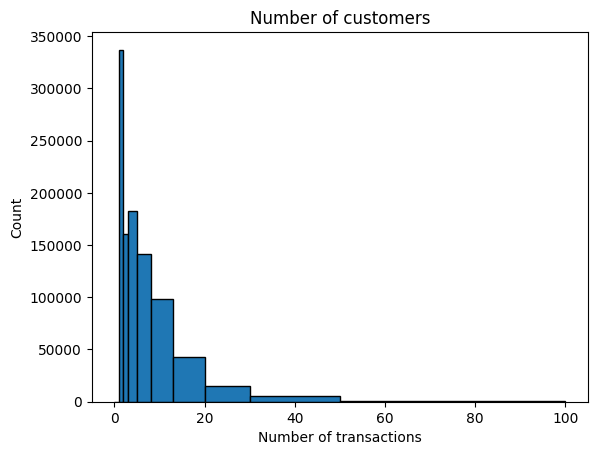

In [39]:
# many have just one purchase but ~ 2/3 have 2 or more

import matplotlib.pyplot as plt

#filtered_data = feature_df.filter(pl.col("total_transactions") <= 20)
data = feature_df["total_transactions"].to_list()

# Define specific ranges for bins
bins = [0, 1, 2, 3, 5, 8, 13, 20, 30, 50, 100]

# Plot histogram
plt.hist(data, bins=bins, edgecolor="black")  # Adding edgecolor for better visibility


plt.xlabel('Number of transactions')
plt.ylabel('Count')
plt.title('Number of customers')
plt.show()


Below we have a simple training and evaluation.

There are:
* 4 features
* labels are unbalanced
* the default parameters
* the features are not standardized not Winsorized

The results are quite good.  I do not have a baseline of a strictly rules based "model" ... but I do wonder.

Logistic Regression:

* AUC (Train): 0.77
* AUC (Test): 0.77

Random Forest:

* AUC (Train): 0.78
* AUC (Test): 0.78

What are these results in business terms for the given use case ... that is, how many catalogs do we need to send to reach X buyers (so we will likely sell the more) and similar peers (where we might persuade them to buy).

After scoring records as of "30 days ago" we can measure the number of buyers by cohort.   For example, how many buyers were there in the top 10% of scored records.  We can then say that we could reach X buyers sending Y catalogs.









In [40]:
import polars as pl

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
#from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.ensemble import RandomForestClassifier

# Align DataFrames on "id"
aligned_df = feature_df.join(label_df, on="customer_id")

# Automatically separate features and labels
excluded_columns = ["customer_id", "label"]  # Columns to exclude
feature_columns = [col for col in aligned_df.columns if col not in excluded_columns]

# Split into features (X) and labels (y)
X = aligned_df.select(feature_columns).to_numpy()
y = aligned_df["label"].to_numpy()

# Step 1: Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(type(X_train))
print(X_train.shape)

# model = LogisticRegression()
model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=1)
model.fit(X_train, y_train)

# Compute AUC for training set
y_train_prob = model.predict_proba(X_train)[:, 1]  # Probabilities for the positive class
train_auc = roc_auc_score(y_train, y_train_prob)

# X_test_balanced, y_test_balanced = smote.fit_resample(X_test, y_test)
# Compute AUC for test set



<class 'numpy.ndarray'>
(787288, 4)


In [41]:
y_test_prob_both = model.predict_proba(X_test)
y_test_prob = y_test_prob_both[:, 1]  # Probabilities for the positive class

test_auc = roc_auc_score(y_test, y_test_prob)

# Output AUC scores
print(f"AUC (Train): {train_auc:.2f}")
print(f"AUC (Test): {test_auc:.2f}")

AUC (Train): 0.78
AUC (Test): 0.78


In [42]:
!pip install scipy==1.11.4

In [43]:
import scipy
print(scipy.__version__)

1.11.4


In [44]:
from sklearn.metrics import precision_recall_curve, f1_score
import numpy as np
precision, recall, thresholds = precision_recall_curve(y_test, y_test_prob)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)
optimal_threshold = thresholds[np.argmax(f1_scores)]

print(f"Optimal Threshold: {optimal_threshold}")




Optimal Threshold: 0.26054843845746606


<Axes: title={'center': 'Confusion Matrix Test'}, xlabel='Predicted label', ylabel='True label'>

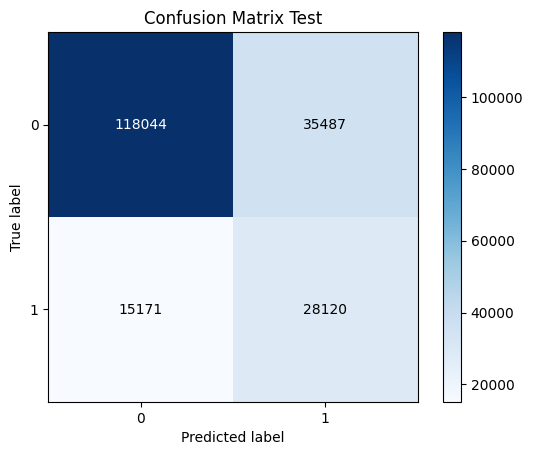

In [45]:
import scikitplot as skplt

y_test_pred = [1 if prob >= optimal_threshold else 0 for prob in y_test_prob]
skplt.metrics.plot_confusion_matrix(y_test, y_test_pred, normalize=False, title = 'Confusion Matrix Test')

<Axes: title={'center': 'ROC Plot Test'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

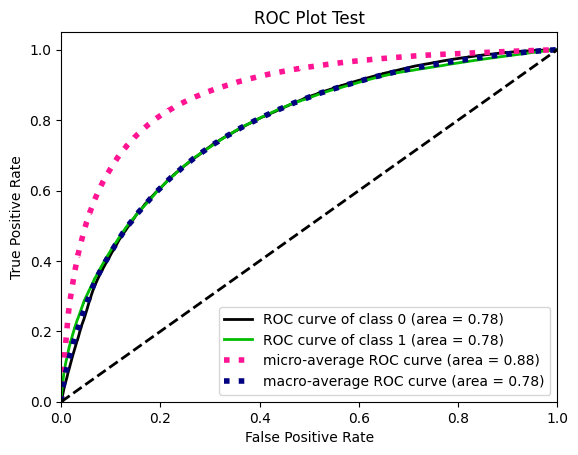

In [46]:
import numpy as np

skplt.metrics.plot_roc(y_test, y_test_prob_both, title = 'ROC Plot Test')



In [47]:
# F1 Scores

f1 = f1_score(y_test, y_test_pred,labels=None, pos_label=1, average='binary', sample_weight=None, zero_division='warn')
print(f1)



0.526109001103856


In [48]:
from sklearn.metrics import precision_recall_curve
import numpy as np

# Calculate precision, recall, and thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_test_prob)

# Compute F1 scores for each threshold
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)  # Avoid divide by zero
optimal_threshold_index = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_threshold_index]

print(f"Optimal Threshold: {optimal_threshold}")
print(f"Maximum F1 Score: {f1_scores[optimal_threshold_index]}")

Optimal Threshold: 0.26054843845746606
Maximum F1 Score: 0.5261090010556619


In [49]:
# Align thresholds with precision/recall (thresholds have one less element)
precision = precision[:-1]
recall = recall[:-1]
f1_scores = f1_scores[:-1]

# Sample every 1000th value
step = 1000
sampled_thresholds = thresholds[::step]
sampled_precision = precision[::step]
sampled_recall = recall[::step]
sampled_f1_scores = f1_scores[::step]

# Print sampled values
print(f"{'Threshold':<10} {'Precision':<10} {'Recall':<10} {'F1 Score':<10}")
for t, p, r, f in zip(sampled_thresholds, sampled_precision, sampled_recall, sampled_f1_scores):
    print(f"{t:<10.4f} {p:<10.4f} {r:<10.4f} {f:<10.4f} ")

Threshold  Precision  Recall     F1 Score  
0.0526     0.2200     1.0000     0.3606     
0.0728     0.2740     0.9406     0.4244     
0.0932     0.2860     0.9269     0.4371     
0.1034     0.3004     0.9048     0.4511     
0.1103     0.3162     0.8823     0.4656     
0.1179     0.3284     0.8626     0.4757     
0.1343     0.3337     0.8544     0.4800     
0.1493     0.3382     0.8483     0.4836     
0.1584     0.3457     0.8347     0.4889     
0.1659     0.3588     0.8115     0.4976     
0.1730     0.3685     0.7930     0.5032     
0.1797     0.3775     0.7780     0.5083     
0.1883     0.3831     0.7675     0.5111     
0.1980     0.3900     0.7539     0.5141     
0.2068     0.3956     0.7427     0.5163     
0.2159     0.4010     0.7317     0.5181     
0.2227     0.4092     0.7160     0.5208     
0.2297     0.4191     0.6972     0.5235     
0.2366     0.4261     0.6832     0.5248     
0.2450     0.4326     0.6699     0.5257     
0.2558     0.4370     0.6588     0.5255     
0.2634     

In [50]:
# okay ... now the back test ... this is true the client facing piece

# score as of one month ago
# for each scored customer collect their purchases the past 30 days
# plot the number scored, number who bought, and response curve

# set parameters for the back test features ... no standardization needed ... no imputation should be necessary yet

# todo: this will be tucked into a function soon
end_date = date(2020,9,22)
feature_duration = 365
backtest_duration = 30
label_duration = 0
label_end =  end_date - timedelta(days=backtest_duration)
feature_end = label_end - timedelta(days=label_duration)
feature_start = feature_end - timedelta(days=feature_duration)

print("feature_start: ", feature_start)
print("feature_end: ", feature_end)


backtest_feature_query = f'''
    SELECT
        t.customer_id
        ,COUNT(1) total_transaction_items
        ,DATE '{feature_end}' - MAX(t.t_dat) as days_since_last
        ,ROUND(590*SUM(price)) as total_revenue --See Kaggle compition news group regarding the 590 factor - todo: get link
        ,COUNT(DISTINCT t.t_dat) as total_transactions
    FROM transactions t
    WHERE t.t_dat <= DATE '{feature_end}' and t.t_dat > DATE '{feature_start}'
    GROUP BY t.customer_id
'''

arrow_table = duckdb_conn.execute(backtest_feature_query).fetch_arrow_table()

backtest_feature_df = pl.from_arrow(arrow_table)

duckdb_conn.register("backtest_features", backtest_feature_df)


feature_start:  2019-08-24
feature_end:  2020-08-23


In [51]:
print(backtest_feature_df.shape)

features_without_id = backtest_feature_df.drop("customer_id")

print(features_without_id.shape)

scores_pred = model.predict_proba(features_without_id.to_numpy())

scores_df = pl.DataFrame({
    "customer_id": backtest_feature_df["customer_id"],
    "score": scores_pred
})

duckdb_conn.register("scores", scores_df)


(985282, 5)
(985282, 4)



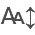

shape: (10, 4)
┌────────┬───────────────┬───────────────────────┬─────────────────┐
│ decile ┆ buyer_count   ┆ scored_customer_count ┆ non_buyer_count │
│ ---    ┆ ---           ┆ ---                   ┆ ---             │
│ i64    ┆ decimal[38,0] ┆ i64                   ┆ decimal[38,0]   │
╞════════╪═══════════════╪═══════════════════════╪═════════════════╡
│ 10     ┆ 4798          ┆ 98528                 ┆ 93730           │
│ 9      ┆ 5459          ┆ 98528                 ┆ 93069           │
│ 8      ┆ 6884          ┆ 98528                 ┆ 91644           │
│ 7      ┆ 9991          ┆ 98528                 ┆ 88537           │
│ 6      ┆ 13029         ┆ 98528                 ┆ 85499           │
│ 5      ┆ 17919         ┆ 98528                 ┆ 80609           │
│ 4      ┆ 23018         ┆ 98528                 ┆ 75510           │
│ 3      ┆ 29994         ┆ 98528                 ┆ 68534           │
│ 2      ┆ 40009         ┆ 98529                 ┆ 58520           │
│ 1      ┆ 61891         ┆ 98529                 ┆ 36638           │
└────────┴───────────────┴───────────────────────┴─────────────────┘

In [52]:
query = f'''

SELECT decile, SUM(bought) buyer_count, COUNT(1) scored_customer_count, COUNT(1) - SUM(bought) non_buyer_count
FROM (
    SELECT s.customer_id, ntile(10) OVER (ORDER BY score) AS decile, COALESCE(bought,0) as bought
    from scores s
    left outer join (
        SELECT customer_id, COUNT(distinct t.customer_id) bought
        from transactions t
        WHERE t_dat > DATE '{feature_end}'
        GROUP BY customer_id
    ) t on t.customer_id = s.customer_id
    GROUP BY s.customer_id, score, bought
) x
GROUP BY decile
ORDER BY decile DESC
'''

backtest_results = run_query_display_results(duckdb_conn, query)

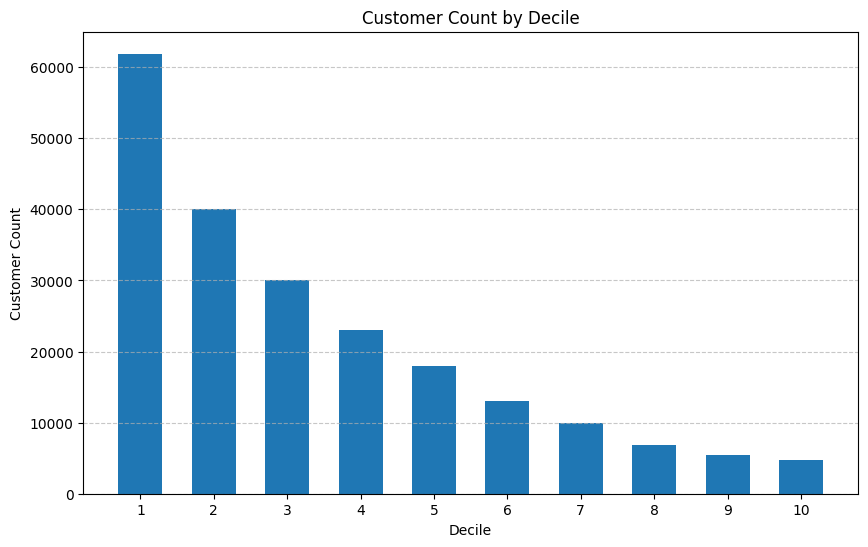

In [53]:
# Extract the values from the DataFrame
decile = backtest_results["decile"].to_list()
customer_count = backtest_results["buyer_count"].to_list()

# Plot the bar chart
plt.figure(figsize=(10, 6))
plt.bar(decile, customer_count, width=0.6)

# Add labels and title
plt.xlabel('Decile')
plt.ylabel('Customer Count')
plt.title('Customer Count by Decile')
plt.xticks(decile)  # Ensure x-axis labels match the deciles
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the chart
plt.show()

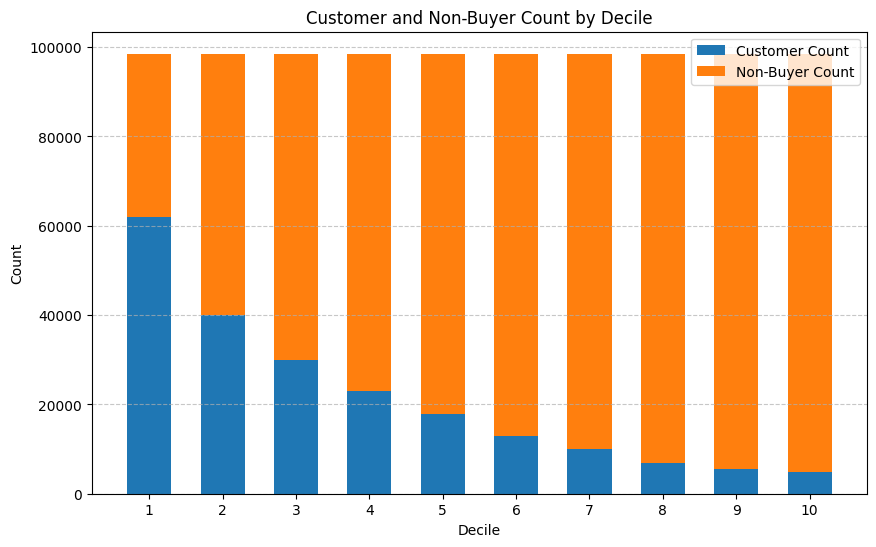

In [54]:
# Extract columns as lists
decile = backtest_results["decile"].to_list()
customer_count = backtest_results["buyer_count"].to_list()
non_buyer_count = backtest_results["non_buyer_count"].to_list()

# Create the stacked bar chart
plt.figure(figsize=(10, 6))
plt.bar(decile, customer_count, label="Customer Count", width=0.6)
plt.bar(decile, non_buyer_count, bottom=customer_count, label="Non-Buyer Count", width=0.6)

# Add labels and title
plt.xlabel('Decile')
plt.ylabel('Count')
plt.title('Customer and Non-Buyer Count by Decile')
plt.xticks(decile)  # Ensure x-axis labels match the deciles
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the chart
plt.show()

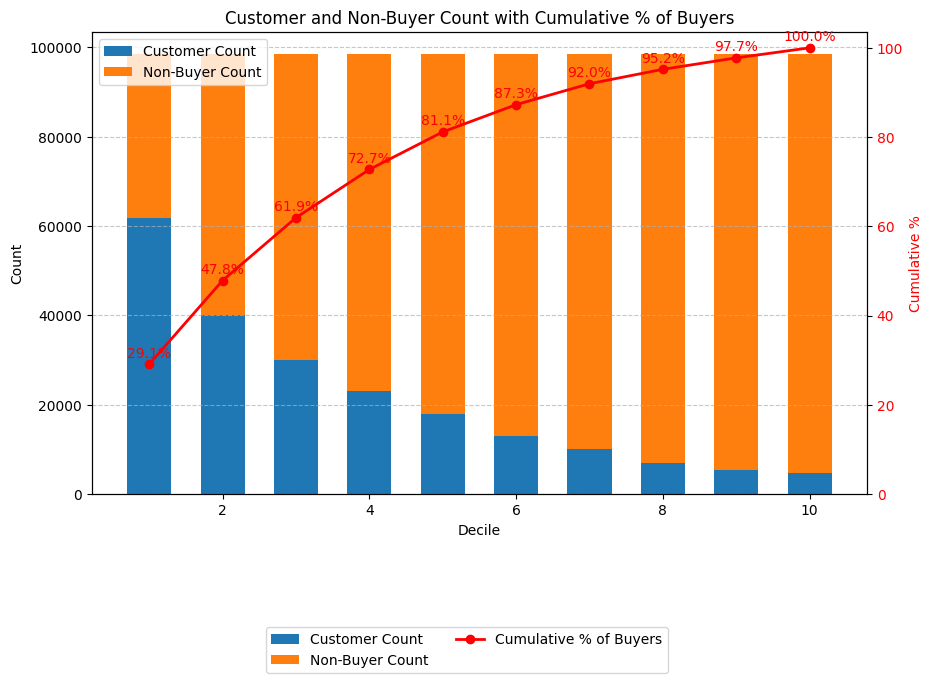

In [55]:
import matplotlib.pyplot as plt

# Assuming data is already created
data = backtest_results.to_pandas()

# Sort the DataFrame by decile in ascending order
data = data.sort_values(by="decile", ascending=True)

data["cumulative_percent"] = (data["buyer_count"].cumsum() / data["buyer_count"].sum() * 100)

# Extract columns as lists
decile = data["decile"].to_list()
customer_count = data["buyer_count"].to_list()
non_buyer_count = data["non_buyer_count"].to_list()
cumulative_percent = data["cumulative_percent"].to_list()

# print(cumulative_percent)
# print(customer_count)

# Create the figure and primary y-axis
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot the stacked bar chart
ax1.bar(decile, customer_count, label="Customer Count", width=0.6)
ax1.bar(decile, non_buyer_count, bottom=customer_count, label="Non-Buyer Count", width=0.6)

# Label for the primary y-axis
ax1.set_xlabel('Decile')
ax1.set_ylabel('Count')
ax1.set_title('Customer and Non-Buyer Count with Cumulative % of Buyers')
ax1.grid(axis='y', linestyle='--', alpha=0.7)
ax1.legend(loc="upper left")

# Create a secondary y-axis for cumulative percent
ax2 = ax1.twinx()
ax2.plot(decile, cumulative_percent, color="red", marker="o", label="Cumulative % of Buyers", linewidth=2)
ax2.set_ylabel('Cumulative %', color='red')
ax2.tick_params(axis='y', labelcolor='red')

for x, y in zip(decile, cumulative_percent):
    ax2.annotate(f"{y:.1f}%", (x, y), textcoords="offset points", xytext=(0, 5), ha='center', color="red")

# Set the secondary y-axis to start at 0
ax2.set_ylim(0, ax2.get_ylim()[1])  # Start from 0, keep the max limit as it is


# Combine legends from both axes
fig.legend(loc="upper center", bbox_to_anchor=(0.5, -0.1), ncol=2)

# Show the plot
plt.show()

# this is not yet how I want it to look but will need to do for the time being


Roughly 30% of buyers are in decile one and 50% in decile one and two.

Presuming we could do no better (but we will see), a marketer could hit 30% of buyers by sending to 10% of active customers.

Besides refactoring the re-usable pieces (let's say I will be creating propensity to buy models for many retailers ... or similar models for different audiences for the same retailer) I will engineer features, modify model parameters (via automate search), and try more advanced models to attempt to increase the % of buyers that fall into the top deciles.

One might think "why market to those who will likely buy anyway"?   Well notice that there are 40% non-buyers in decile one.  These could be considered look-a-likes to the buyers and you want to try to nudge them to convert.   Also, in my experience, it is not just an increase in conversions but also AOV that increases via target marketing (versus a holdout).  So even if decile one contained all buyers (when backtesting) it is very like profitable to market to them none-the-less as they will buy more (increase their Average Order Value).





              precision    recall  f1-score   support

           0       0.89      0.77      0.82    153531
           1       0.44      0.65      0.53     43291

    accuracy                           0.74    196822
   macro avg       0.66      0.71      0.67    196822
weighted avg       0.79      0.74      0.76    196822



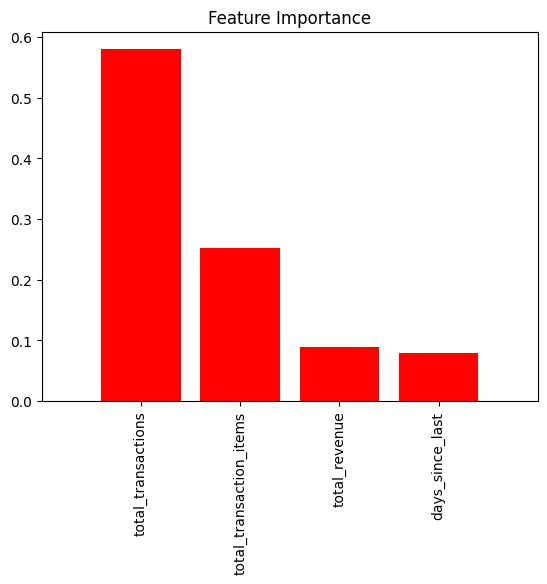

In [56]:
# other options for output metric display

from sklearn.metrics import classification_report

print(classification_report(y_test, y_test_pred))

# Feature Importance
importance = model.feature_importances_
indices = np.argsort(importance)[::-1]

plt.figure()
plt.title("Feature Importance")
plt.bar(range(X.shape[1]), importance[indices], color="r", align="center")
plt.xticks(range(X.shape[1]), [feature_columns[i] for i in indices], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.show()